In [41]:
!pip install graphviz
!pip install xgboost

  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 870.8 kB/s eta 0:00:000:00:01


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# try a bigger augmented full dataset
train_aug_full = pd.read_csv('train_augmented_full.csv')

In [6]:
train_aug_full.columns

Index(['name', 'description', 'property_type', 'price',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'instant_bookable',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'rev

In [7]:
train_aug_full.shape

(15696, 94)

In [4]:
train_aug_full_selected = train_aug_full.copy()[['price',
       'neighbourhood_group_cleansed', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'instant_bookable',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month', 'has_reviews',
       'amenities_count', 'host_time', 'first_review_time',
       'last_review_time', 'review_time_difference', 'entire_homes_ratio',
       'private_rooms_ratio', 'review_scores_rating_scaled',
       'review_scores_accuracy_scaled', 'review_scores_cleanliness_scaled',
       'review_scores_checkin_scaled', 'review_scores_communication_scaled',
       'review_scores_location_scaled', 'review_scores_value_scaled', 'reviews_safe',
       'reviews_convenient', 'reviews_clean', 'reviews_quiet',
       'reviews_luxury', 'name_new', 'name_luxury', 'name_big', 'reviews_big',
       'description_luxury', 'description_big', 'description_convenient',
       'is_entire_rental_unit', 'is_private_room_in_rental_unit',
       'is_private_room_in_home', 'is_entire_home',
       'is_private_room_in_townhouse', 'is_private_room_in_hotel',
       'is_entire_condo', 'distance_to_times_square']]

In [5]:
train_aug_full_selected.shape

(15696, 62)

### Linear Regression

I first convert all categorical variables to numerical variables.

Mappings are as follows:

room_type -> Entire home/apt: 0, Single Room: 1

neighbourhood_group_cleansed -> Bronx: 0, Brooklyn: 1, Manhattan: 2, Queens: 3, Staten Island: 4

host_response_time -> 
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2,
    'a few days or more': 3

instant_bookable -> True: 1, False: 0

host_identity_verified -> True: 1, False: 0

In [8]:
train_selected = train_aug_full.copy()[['distance_to_times_square', 'room_type', 'name_luxury', 'description_luxury',
       'accommodates', 'neighbourhood_group_cleansed', 'amenities_count',
       'beds', 'bedrooms', 'instant_bookable', 'host_response_time',
       'host_acceptance_rate', 'host_response_rate', 'host_identity_verified',
       'entire_homes_ratio', 'calculated_host_listings_count_private_rooms', 'has_reviews', 'review_scores_rating',
       'review_scores_location', 'reviews_convenient', 'reviews_quiet',
       'reviews_clean', 'price']]

In [9]:
print(train_selected.shape)

(15696, 23)


In [10]:
# one-hot encode the categorical features
categorical_vars = train_selected.select_dtypes(include=['object','bool']).columns
exclude_vars = ['host_response_time']
categorical_vars = [var for var in categorical_vars if var not in exclude_vars]
# one-hot encode the categorical features
if 'host_response_time' in train_selected.columns:
    mapping = {'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3}
    train_selected['host_response_time'] = train_selected['host_response_time'].map(mapping)
train_selected = pd.get_dummies(train_selected, columns=categorical_vars, drop_first=True)
print(train_selected.head())

   distance_to_times_square  name_luxury  description_luxury  accommodates  \
0                  9.026255            0                   0             4   
1                 13.337586            0                   0             2   
2                 15.973986            0                   0             2   
3                  9.713780            0                   0             1   
4                  1.203165            0                   0             2   

   amenities_count  beds  bedrooms  host_response_time  host_acceptance_rate  \
0              617   2.0       2.0                   2                 100.0   
1              660   2.0       1.0                   0                  98.0   
2              628   1.0       0.0                   0                 100.0   
3              175   1.0       4.0                   0                  23.0   
4              391   1.0       1.0                   0                  95.0   

   host_response_rate  ...  price  room_type_Hotel

I perform the same 5-fold training and validation set split for cross validation across all models during training. The same folds are used for both model evaluation and model training or selection purposes. I also created a train-test split to have a held-out test set with known true labels for model evaluation.

In [11]:
# data split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X = train_selected.drop('price',axis=1)
y = train_selected['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

I first fit a linear regression model using all of the selected variables and no interaction variables. The predicted float values are rounded to the nearest integer value below the integer threshold (e.g. 2.9 is converted to 3, but 5.6 is converted to 5 instead of 6). The predicted values are clipped between 0 and 5 to yield reasonable predictions within the range of the target variable.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
linreg_pred = np.round(linreg.predict(X_test)).astype(int)
linreg_pred = np.clip(linreg_pred, 0, 5)

r2 = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2')
mse = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("cv r2: ", np.mean(r2))
print("cv mse: ", np.sqrt(-np.mean(mse)))
print(linreg.coef_)
r2_test = linreg.score(X_test, y_test)
mse_test = np.sqrt(mean_squared_error(y_test, linreg_pred))
accuracy_test =  accuracy_score(y_test, linreg_pred)
print("Test R2: ", r2_test)
print("Test MSE: ", mse_test)
print("Test Accuracy: ", accuracy_test)

cv r2:  0.5299427710620546
cv mse:  1.1701641008924928
[-6.19075105e-02  2.66230805e-01  3.03098290e-01  1.55602142e-01
  6.92237374e-04  6.20241561e-02  2.00345421e-01 -1.31689104e-01
  2.08853958e-03 -2.45967827e-03  5.67307292e-01 -2.30603707e-03
 -3.81132681e-01  4.83255771e-02  2.21947387e-01 -1.57036194e-02
  2.64809680e-02  5.79054903e-02 -1.02964982e-01 -5.61086540e-01
 -9.16785081e-01  3.75444901e-01  6.52411460e-01  1.90839645e-01
  3.74850562e-01  5.33841550e-01  8.44337233e-02]
Test R2:  0.5343019725194382
Test MSE:  1.208515433968523
Test Accuracy:  0.3394904458598726


I then experiment with interaction variables and transformations of the variables.

In [150]:
train_selected['review_scores_location_sq'] = train_selected['review_scores_location'] ** 2
corr = train_selected['review_scores_location_sq'].corr(train_selected['price'])
print(corr)

train_selected['host_acceptance_rate_sq'] = train_selected['host_acceptance_rate'] ** 2
corr = train_selected['host_acceptance_rate_sq'].corr(train_selected['price'])
print(corr)

0.13250614559608057
0.17202856815120665


In [92]:
X_transformed = train_selected.drop(['price','review_scores_location','host_acceptance_rate'], axis=1)
y = train_selected['price']

linreg = LinearRegression().fit(X_transformed, y)
r2 = cross_val_score(linreg, X_transformed, y, cv=cv, scoring='r2')
mse = cross_val_score(linreg, X_transformed, y, cv=cv, scoring='neg_mean_squared_error')
print("r2: ", r2)
print("mse: ", mse)
print(linreg.coef_)

r2:  [0.43616149 0.43401769 0.4377272  0.43589758 0.42734568]
mse:  [-1.66311774 -1.67443486 -1.66210438 -1.63007832 -1.63501796]
[-5.72829855e-01  2.00232243e-01  1.75992016e-02  6.21694227e-04
  7.17910011e-02  6.49502433e-01 -9.23161366e-02 -3.00370646e-03
  2.12602767e-01  9.10978305e-01 -3.97794704e-01 -1.12712710e-01
  1.10188669e-02 -1.09116973e-01  5.78788349e-02  7.28407320e-02
  4.13128466e-05]


Interaction terms were added.

In [171]:
corr1 = train_selected['beds'].corr(train_selected['accommodates'])
corr2 = train_selected['host_response_rate'].corr(train_selected['host_acceptance_rate'])
print(corr1, corr2)

0.7342967850888418 0.538011256521058


In [169]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

train_selected['beds_accommodates_interaction'] = train_selected['beds'] * train_selected['accommodates']
train_selected['host_response_acceptance_rate_interaction'] = (
    train_selected['host_response_rate'] * train_selected['host_acceptance_rate']
)

X = train_selected.drop('price', axis=1)
y = train_selected['price']

X_interaction_train, X_interaction_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

linreg = LinearRegression().fit(X_interaction_train, y_train)

cv = 5  
r2 = cross_val_score(linreg, X_interaction_train, y_train, cv=cv, scoring='r2')
mse = cross_val_score(linreg, X_interaction_train, y_train, cv=cv, scoring='neg_mean_squared_error')
print("CV R2: ", np.mean(r2))
print("CV MSE: ", np.sqrt(-np.mean(mse)))
print("Coefficients: ", linreg.coef_)

linreg_pred = np.round(linreg.predict(X_interaction_test)).astype(int)
linreg_pred = np.clip(linreg_pred, 0, 5)

# Test scores
r2_test = linreg.score(X_interaction_test, y_test)
mse_test = np.sqrt(mean_squared_error(y_test, linreg_pred))
accuracy_test = accuracy_score(y_test, linreg_pred)

print("Test R2: ", r2_test)
print("Test MSE: ", mse_test)
print("Test Accuracy: ", accuracy_test)


CV R2:  0.5369531670941049
CV MSE:  1.1612651499849789
Coefficients:  [-6.20192615e-02  2.57282146e-01  2.92388128e-01  2.46731119e-01
  6.59761222e-04  2.40262330e-01  2.00035998e-01 -1.25215608e-01
 -2.62506762e-03 -4.18775196e-03  5.39880189e-01 -2.21109219e-03
 -3.83069587e-01  5.63443309e-02  2.04710737e-01 -2.20685947e-02
  2.80103844e-02  5.02839440e-02 -3.33502796e-02  5.40111104e-05
 -8.53664079e-02 -5.19565880e-01 -8.93097273e-01  3.78574790e-01
  6.60953615e-01  1.88406830e-01  3.72725000e-01  5.18839765e-01
  8.98735422e-02]
Test R2:  0.5399674045198837
Test MSE:  1.2066693645792175
Test Accuracy:  0.33885350318471336


Variable selection using LASSO, forward, backward selection.

In [195]:
# lasso
from sklearn.linear_model import LassoCV

# Perform Lasso with cross-validation
lasso_cv = LassoCV(cv=cv, random_state=42)
lasso_cv.fit(X_interaction_train, y_train)
# Get the best alpha and coefficients
best_alpha = lasso_cv.alpha_
best_coef = lasso_cv.coef_
selected_features = X_interaction_train.columns[best_coef != 0].values

# Features selected by Lasso
print("Lasso Linear Regression Model:")
print(f"Best alpha: {best_alpha}")
print("Intercept:", lasso_cv.intercept_)
print("\nSelected Features and Coefficients:")
for feature, coef in zip(selected_features, best_coef[best_coef != 0]):
    print(f"  {feature}: {coef:.9f}")


y_train_pred = np.round(lasso_cv.predict(X_interaction_train)).astype(int)
y_test_pred = np.round(lasso_cv.predict(X_interaction_test)).astype(int)
y_train_pred = np.clip(y_train_pred, 0, 5)
y_test_pred = np.clip(y_test_pred, 0, 5)

cv_accuracy = accuracy_score(y_train, y_train_pred)
print("Cross-Validation Accuracy:", cv_accuracy)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)


Lasso Linear Regression Model:
Best alpha: 0.8102832002865983
Intercept: 2.2557352759887292

Selected Features and Coefficients:
  distance_to_times_square: -0.092963047
  amenities_count: 0.000826676
  calculated_host_listings_count_private_rooms: -0.002795327
  beds_accommodates_interaction: 0.039120042
  host_response_acceptance_rate_interaction: 0.000045957
Cross-Validation Accuracy: 0.2519467648308084
Test Accuracy: 0.2585987261146497


In [188]:
# forward and backward selection
from sklearn.feature_selection import SequentialFeatureSelector

model = LinearRegression()

# Forward Selection
sfs_forward = SequentialFeatureSelector(model, n_features_to_select=15, direction='forward', scoring='neg_mean_squared_error', cv=cv)
sfs_forward.fit(X_interaction_train, y_train)
print("Selected features (Forward Selection):", X_interaction_train.columns[sfs_forward.get_support()].tolist())

# Backward Selection
sfs_backward = SequentialFeatureSelector(model, n_features_to_select=15, direction='backward', scoring='neg_mean_squared_error', cv=cv)
sfs_backward.fit(X_interaction_train, y_train)
print("Selected features (Backward Selection):", X_interaction_train.columns[sfs_backward.get_support()].tolist())

Selected features (Forward Selection): ['distance_to_times_square', 'description_luxury', 'accommodates', 'amenities_count', 'bedrooms', 'host_response_time', 'entire_homes_ratio', 'calculated_host_listings_count_private_rooms', 'has_reviews', 'review_scores_location', 'beds_accommodates_interaction', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_group_cleansed_Manhattan', 'instant_bookable_True']
Selected features (Backward Selection): ['distance_to_times_square', 'description_luxury', 'accommodates', 'amenities_count', 'beds', 'bedrooms', 'host_response_time', 'entire_homes_ratio', 'calculated_host_listings_count_private_rooms', 'has_reviews', 'review_scores_location', 'beds_accommodates_interaction', 'room_type_Private room', 'neighbourhood_group_cleansed_Manhattan', 'instant_bookable_True']


In [196]:
cols = X_interaction_train.columns[sfs_forward.get_support()].tolist()
X_interaction_train_selection = X_interaction_train[cols]
X_interaction_test_selection = X_interaction_test[cols]
print(X_interaction_test_selection.dtypes)
model.fit(X_interaction_train_selection, y_train)
y_test_pred = np.floor(model.predict(X_interaction_test_selection)).astype(int)
y_test_pred = np.clip(y_test_pred, 0, 5)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("backward/forward selection Test Accuracy:", test_accuracy)
print("rmse: ", np.sqrt(mean_squared_error(y_test, y_test_pred)))
unique_values, counts = np.unique(y_test_pred, return_counts=True)
print(unique_values, counts)

distance_to_times_square                        float64
description_luxury                                int64
accommodates                                      int64
amenities_count                                   int64
bedrooms                                        float64
host_response_time                                int64
entire_homes_ratio                              float64
calculated_host_listings_count_private_rooms      int64
has_reviews                                       int64
review_scores_location                          float64
beds_accommodates_interaction                   float64
room_type_Private room                             bool
room_type_Shared room                              bool
neighbourhood_group_cleansed_Manhattan             bool
instant_bookable_True                              bool
dtype: object
backward/forward selection Test Accuracy: 0.3484076433121019
rmse:  1.313331932274248
[0 1 2 3 4 5] [204 382 399 417 146  22]


Best test accuracy from linear regression models: 0.303

Model: linear regression model with interaction terms.

### Decision Trees

In [13]:
# one-hot encode the categorical features
categorical_vars = train_aug_full_selected.select_dtypes(include=['object','bool']).columns
exclude_vars = ['host_response_time']
categorical_vars = [var for var in categorical_vars if var not in exclude_vars]
# one-hot encode the categorical features
if 'host_response_time' in train_aug_full_selected.columns:
    mapping = {'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3}
    train_aug_full_selected['host_response_time'] = train_aug_full_selected['host_response_time'].map(mapping)
train_aug_full_selected = pd.get_dummies(train_aug_full_selected, columns=categorical_vars, drop_first=True)
print(train_aug_full_selected.head())

   price  host_response_time  host_response_rate  host_acceptance_rate  \
0      4                   2               100.0                 100.0   
1      3                   0               100.0                  98.0   
2      3                   0               100.0                 100.0   
3      0                   0                99.0                  23.0   
4      2                   0                93.0                  95.0   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                              52   
3                             719   
4                              73   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            0   
2                                           50   
3                                            0   
4                                            0   

   calculated_host_listings_cou

In [15]:
# classifier: find best parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

def custom_rmse(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).astype(int)  
    y_pred_clipped = np.clip(y_pred_rounded, 0, 5)  
    return np.sqrt(mean_squared_error(y_true, y_pred_clipped))

rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)

scoring = {
    'accuracy': 'accuracy',
    'neg_mean_squared_error': 'neg_mean_squared_error',
}

max_depth_grid = {'max_depth': np.arange(6,11)}
max_leaf_nodes_grid = {'max_leaf_nodes': [40, 45, 50, 55, 60]}
min_samples_split_grid = {'min_samples_split': [5,6,7]}
min_samples_leaf_grid = {'min_samples_leaf': np.arange(10,20,1)}

param_grid = {**max_depth_grid,
              **max_leaf_nodes_grid,
              **min_samples_split_grid,
              **min_samples_leaf_grid}

tree = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=tree,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=rmse_scorer,
                           n_jobs=-1,
                           refit='neg_mean_squared_error',
                           error_score='raise')

grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_['max_depth']
best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
print("best parameters:")
print("best max_depth: ", best_max_depth)
print("best max_leaf_nodes: ", best_max_leaf_nodes)
print("best min_samples_split: ", best_min_samples_split)
print("best min_samples_leaf: ", best_min_samples_leaf)

best parameters:
best max_depth:  9
best max_leaf_nodes:  60
best min_samples_split:  5
best min_samples_leaf:  10


In [123]:
# try regressor
from sklearn.metrics import mean_squared_error, make_scorer

def custom_rmse(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).astype(int)  
    y_pred_clipped = np.clip(y_pred_rounded, 0, 5)  
    return np.sqrt(mean_squared_error(y_true, y_pred_clipped))

def custom_accuracy(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_clipped = np.clip(y_pred_rounded, 0, 5)
    return np.mean(y_true == y_pred_clipped)

rmse_scorer = make_scorer(custom_rmse, greater_is_better=False)
accuracy_scorer = make_scorer(custom_accuracy, greater_is_better=True)

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeRegressor

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

max_depth_grid = {'max_depth': np.arange(6,11)}
max_leaf_nodes_grid = {'max_leaf_nodes': np.arange(40,65,5)}
min_samples_split_grid = {'min_samples_split': np.arange(5,21,1)}
min_samples_leaf_grid = {'min_samples_leaf': np.arange(10,21,1)}

param_grid = {**max_depth_grid,
              **max_leaf_nodes_grid,
              **min_samples_split_grid,
              **min_samples_leaf_grid}

scoring = {'rmse': rmse_scorer, 'accuracy': accuracy_scorer}

tree = DecisionTreeRegressor(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=tree,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=scoring,
                           n_jobs=-1,
                           refit='rmse',
                           error_score='raise')

grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_['max_depth']
best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
print("best parameters:")
print("best max_depth: ", best_max_depth)
print("best max_leaf_nodes: ", best_max_leaf_nodes)
print("best min_samples_split: ", best_min_samples_split)
print("best min_samples_leaf: ", best_min_samples_leaf)

best parameters:
best max_depth:  10
best max_leaf_nodes:  60
best min_samples_split:  5
best min_samples_leaf:  11


{'mean_fit_time': array([0.11882839, 0.16656418, 0.14728293, ..., 0.12275305, 0.1207705 ,
       0.11067224]), 'std_fit_time': array([0.02591708, 0.03468688, 0.04129983, ..., 0.00400777, 0.00476545,
       0.00330325]), 'mean_score_time': array([0.00301957, 0.00350976, 0.00244761, ..., 0.00172777, 0.00178556,
       0.00146108]), 'std_score_time': array([1.13192245e-03, 2.21991371e-03, 6.61500174e-04, ...,
       4.00772353e-04, 6.26666922e-04, 7.59726554e-05]), 'param_max_depth': masked_array(data=[6, 6, 6, ..., 10, 10, 10],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_max_leaf_nodes': masked_array(data=[40, 40, 40, ..., 60, 60, 60],
             mask=[False, False, False, ..., False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[10, 10, 10, ..., 20, 20, 20],
             mask=[False, False, False, ..., False, False, False],
       fill_value='

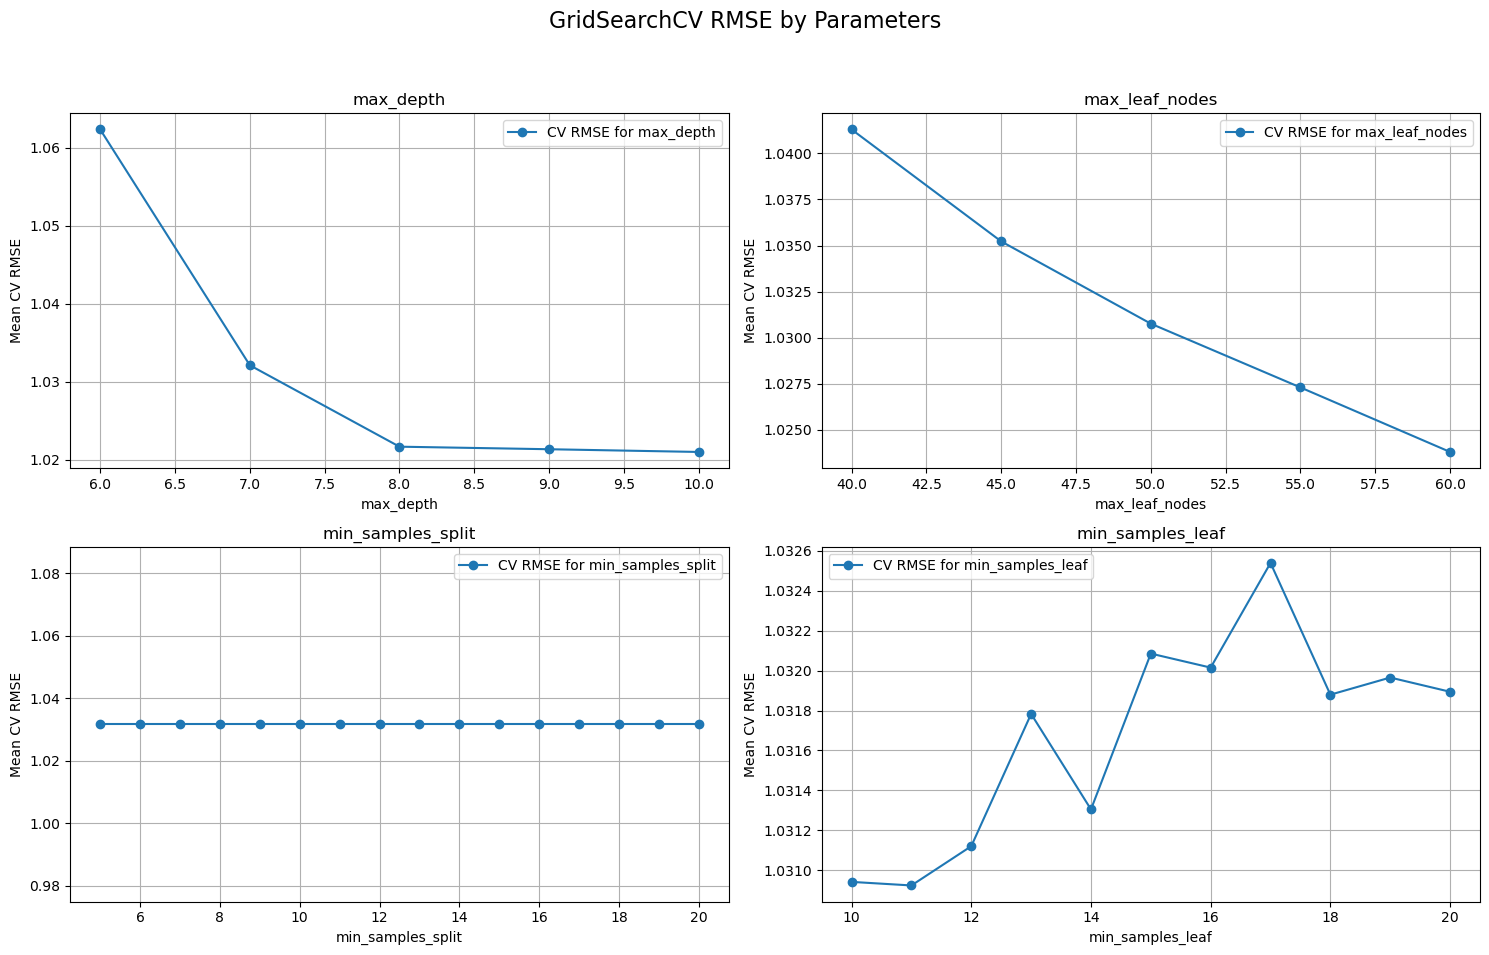

In [137]:
# plot graph of RMSE by params

results = grid_search.cv_results_
print(results)
params = results['params']
mean_test_score = results['mean_test_rmse']

scores_by_param = {
    'max_depth': {},
    'max_leaf_nodes': {},
    'min_samples_split': {},
    'min_samples_leaf': {}
}

# aggregatee scores by parameter value
for i, param_set in enumerate(params):
    for param_name in param_set:
        param_value = param_set[param_name]
        if param_value not in scores_by_param[param_name]:
            scores_by_param[param_name][param_value] = []
        scores_by_param[param_name][param_value].append(mean_test_score[i])

# average the scores for each parameter value
for param_name in scores_by_param:
    for param_value in scores_by_param[param_name]:
        scores_by_param[param_name][param_value] = np.mean(scores_by_param[param_name][param_value])

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns
fig.suptitle('GridSearchCV RMSE by Parameters', fontsize=16)

# List of parameters and their subplot positions
param_names = list(scores_by_param.keys())
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # Subplot positions (row, column)

# Plot each parameter in its corresponding subplot
for i, param_name in enumerate(param_names):
    row, col = positions[i]
    scores = scores_by_param[param_name]
    axs[row, col].plot(list(scores.keys()), [-x for x in scores.values()], marker='o', label=f'CV RMSE for {param_name}')  # Flip RMSE to positive
    axs[row, col].set_title(f'{param_name}', fontsize=12)
    axs[row, col].set_xlabel(param_name, fontsize=10)
    axs[row, col].set_ylabel('Mean CV RMSE', fontsize=10)
    axs[row, col].grid(True)
    axs[row, col].legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()

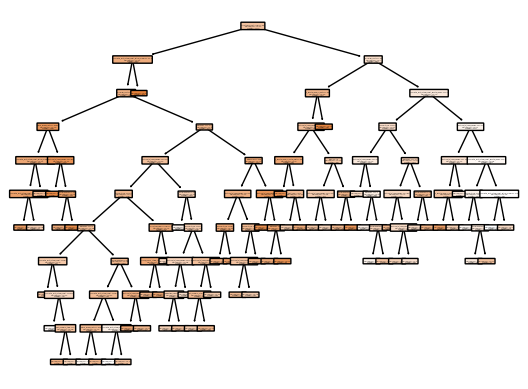

'best_decision_tree_full_regressor.pdf'

In [144]:
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

best_tree_regressor = DecisionTreeRegressor(max_depth=10,
                                   max_leaf_nodes=60,
                                   min_samples_split=5,
                                   min_samples_leaf=11,
                                   random_state=42)
best_tree_regressor.fit(X_train, y_train)

def get_rounded_node_values(tree, class_labels):
    rounded_values = []
    for value in tree.value:
        node_value = np.clip(np.round(value).astype(int), class_labels[0], class_labels[-1])
        rounded_values.append(node_value.squeeze())
    return rounded_values

# Apply rounding to node values
get_rounded_node_values(best_tree_regressor.tree_, np.array([0, 1, 2, 3, 4, 5]))

plot_tree(best_tree_regressor, filled=True, rounded=True, feature_names=X.columns.to_list())
plt.show()

# export tree pdf
dot_data = export_graphviz(best_tree_regressor, out_file=None,
                            feature_names=X.columns.to_list(),
                            filled=True, rounded=True,
                            special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("best_decision_tree_full_regressor")

In [142]:
# report performance on test set
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

best_tree_regressor = DecisionTreeRegressor(max_depth=10,
                                   max_leaf_nodes=60,
                                   min_samples_split=20,
                                   min_samples_leaf=11,
                                   random_state=42)

best_tree_regressor.fit(X_train, y_train)



best_tree = DecisionTreeClassifier(max_depth=8,
                                   max_leaf_nodes=45,
                                   min_samples_split=5,
                                   min_samples_leaf=19,
                                   random_state=42)
best_tree.fit(X_train, y_train)


y_pred = best_tree_regressor.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)  
y_pred_clipped = np.clip(y_pred_rounded, 0, 5)  
accuracy = accuracy_score(y_test, y_pred_clipped)
print(f"Accuracy: {accuracy:.4f}")
print(f"rmse: ", np.sqrt(mean_squared_error(y_test, y_pred_clipped)))

unique_classes, class_counts = np.unique(y_pred_clipped, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} instances")

unique_classes, class_counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} instances")   

y_pred = best_tree.predict(X_test)
print(f"Accuracy: {accuracy:.4f}")
print(f"rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))



Accuracy: 0.4713
rmse:  0.9845947143837187
Class 0: 207 instances
Class 1: 272 instances
Class 2: 303 instances
Class 3: 416 instances
Class 4: 207 instances
Class 5: 165 instances
Class 0: 280 instances
Class 1: 254 instances
Class 2: 249 instances
Class 3: 275 instances
Class 4: 234 instances
Class 5: 278 instances
Accuracy: 0.4713
rmse:  1.1201683222014869


Hyperparameter Tuning

best max_depth:  10
best max_leaf_nodes:  45
best min_samples_split:  5
best min_samples_leaf:  5

test accuracy:  0.4924

**For full data (including distance to times square and property types):**

best parameters:
best max_depth:  9
best max_leaf_nodes:  45
best min_samples_split:  5
best min_samples_leaf:  19

Accuracy: 0.5752
rmse:  1.1387779795132165

**For full augmented data:**

**best parameters:**
best max_depth:  8
best max_leaf_nodes:  45
best min_samples_split:  5
best min_samples_leaf:  19

**Test Accuracy**: 0.5446
Test rmse:  1.2077246069011964

For full data (excluding neighbourhood_group_cleansed):

best parameters:
best max_depth:  10
best max_leaf_nodes:  45
best min_samples_split:  5
best min_samples_leaf:  19

test accuracy: 0.5510

For full data (including neighbourhood_group_cleansed):

best max_depth:  10
best max_leaf_nodes:  45
best min_samples_split:  5
best min_samples_leaf:  5

test accuracy: 0.5669

submission rmse: 1.14327

After adding 'neg_mean_squared_error' to scoring:

best parameters:
best max_depth:  9
best max_leaf_nodes:  45
best min_samples_split:  5
best min_samples_leaf:  13

test accuracy: 0.5631

In [147]:
# feature importances
import numpy as np

tree = best_tree_regressor.tree_

feature_importances = best_tree_regressor.feature_importances_
features = X_train.columns

node_samples = tree.weighted_n_node_samples
impurity = tree.impurity
feature_indices = tree.feature

gini_reduction = {feature: [] for feature in features}

for node_idx in range(tree.node_count):
    if feature_indices[node_idx] == -2:
        continue
    
    feature_idx = feature_indices[node_idx]
    feature_name = features[feature_idx]
    
    left_child = tree.children_left[node_idx]
    right_child = tree.children_right[node_idx]
    weighted_gini_reduction = (
        node_samples[node_idx] * impurity[node_idx]
        - node_samples[left_child] * impurity[left_child]
        - node_samples[right_child] * impurity[right_child]
    )
    
    gini_reduction[feature_name].append(weighted_gini_reduction)

average_gini_reduction = {feature: np.mean(reductions) if reductions else 0
                          for feature, reductions in gini_reduction.items()}

sorted_gini_reduction = sorted(average_gini_reduction.items(), key=lambda x: x[1], reverse=True)

print("Average Gini Impurity Reduction:")
for feature, avg_gini in sorted_gini_reduction:
    print(f"{feature}: {avg_gini:.4f}")

print("\nFeature Importance from Tree:")
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance:.4f}")

Average Gini Impurity Reduction:
room_type_Private room: 11952.0022
minimum_nights: 2694.5236
is_private_room_in_hotel: 745.1696
calculated_host_listings_count_entire_homes: 690.2189
bathrooms: 625.0909
calculated_host_listings_count_private_rooms: 475.9132
bedrooms: 383.5958
availability_60: 188.7001
distance_to_times_square: 168.5146
availability_90: 158.8703
beds: 158.1486
calculated_host_listings_count: 138.0266
is_private_room_in_rental_unit: 121.4849
entire_homes_ratio: 96.8086
accommodates: 87.6879
room_type_Shared room: 82.9817
host_time: 59.9818
calculated_host_listings_count_shared_rooms: 56.0748
review_scores_rating_scaled: 46.8396
amenities_count: 44.4527
host_response_time: 39.6961
host_response_rate: 34.8523
host_acceptance_rate: 0.0000
availability_30: 0.0000
availability_365: 0.0000
maximum_nights: 0.0000
number_of_reviews: 0.0000
number_of_reviews_ltm: 0.0000
number_of_reviews_l30d: 0.0000
reviews_per_month: 0.0000
has_reviews: 0.0000
first_review_time: 0.0000
last_rev

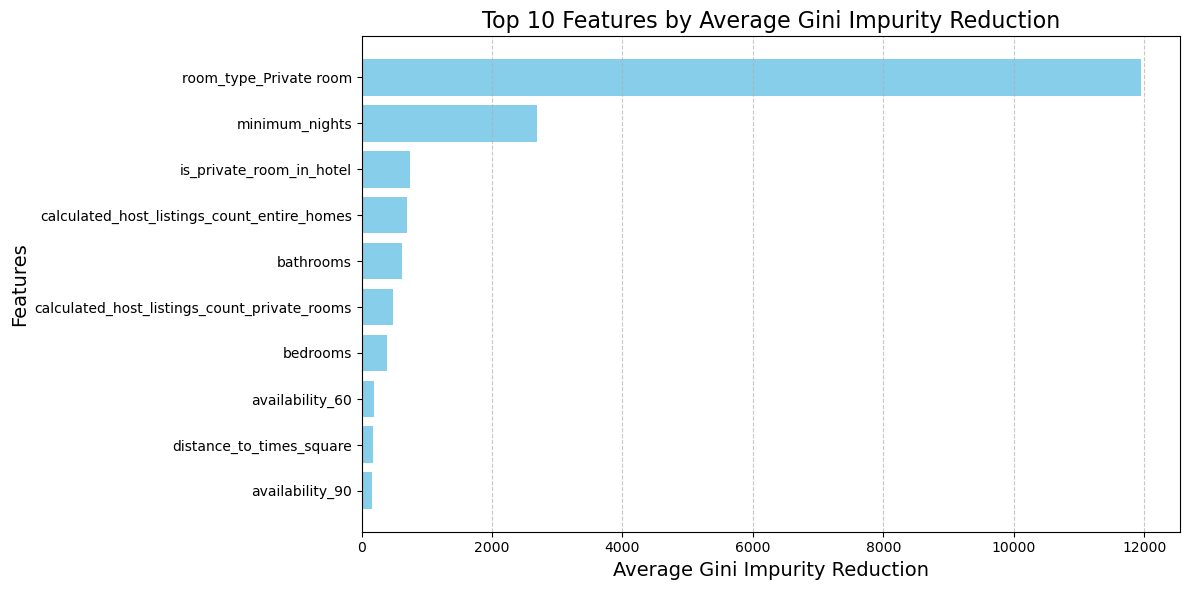

In [148]:
# plot graph for top 10 features

features_top_10, gini_values_top_10 = zip(*sorted_gini_reduction[:10])

plt.figure(figsize=(12, 6))
plt.barh(features_top_10, gini_values_top_10, color='skyblue')
plt.xlabel('Average Gini Impurity Reduction', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 10 Features by Average Gini Impurity Reduction', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'neg_mean_squared_error': 'neg_mean_squared_error',
}

# max_depth_grid = {'max_depth': np.arange(6,11)}
# max_leaf_nodes_grid = {'max_leaf_nodes': [45, 50, 55]}
# min_samples_split_grid = {'min_samples_split': [4,5,6]}
# min_samples_leaf_grid = {'min_samples_leaf': np.arange(15,26,1)}
n_estimators_grid = {'n_estimators': [450, 500, 550, 600]}

param_grid = {**n_estimators_grid}

rf = RandomForestClassifier(criterion='gini',
                            max_depth=8,
                            max_leaf_nodes=45,
                            min_samples_leaf=19,
                            random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=scoring,
                           n_jobs=-1,
                           refit='neg_mean_squared_error',
                           error_score='raise')

grid_search.fit(X_train, y_train)

# best_max_depth = grid_search.best_params_['max_depth']
# best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
# best_min_samples_split = grid_search.best_params_['min_samples_split']
# best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_n_estimators = grid_search.best_params_['n_estimators']
print("best parameters:")
# print("best max_depth: ", best_max_depth)
# print("best max_leaf_nodes: ", best_max_leaf_nodes)
# print("best min_samples_split: ", best_min_samples_split)
# print("best min_samples_leaf: ", best_min_samples_leaf)
print((f"Best n_estimators: {best_n_estimators}"))
print(f"Best score: {grid_search.best_score_}")

best parameters:
Best n_estimators: 450
Best score: -1.2506070934245221


In [16]:
# try regressor
from sklearn.ensemble import RandomForestRegressor

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'neg_mean_squared_error': 'neg_mean_squared_error',
}

# max_depth_grid = {'max_depth': np.arange(6,11)}
# max_leaf_nodes_grid = {'max_leaf_nodes': [45, 50, 55]}
# min_samples_split_grid = {'min_samples_split': [4,5,6]}
# min_samples_leaf_grid = {'min_samples_leaf': np.arange(15,26,1)}
n_estimators_grid = {'n_estimators': [450, 500, 550, 600]}

param_grid = {**n_estimators_grid}

rf = RandomForestRegressor(criterion='squared_error',
                            max_depth=10,
                            max_leaf_nodes=60,
                            # min_samples_split=5,
                            min_samples_leaf=11,
                            random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=cv,
                           scoring=rmse_scorer,
                           n_jobs=-1,
                           refit='neg_mean_squared_error',
                           error_score='raise')

grid_search.fit(X_train, y_train)

# best_max_depth = grid_search.best_params_['max_depth']
# best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
# best_min_samples_split = grid_search.best_params_['min_samples_split']
# best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
best_n_estimators = grid_search.best_params_['n_estimators']
print("best parameters:")
# print("best max_depth: ", best_max_depth)
# print("best max_leaf_nodes: ", best_max_leaf_nodes)
# print("best min_samples_split: ", best_min_samples_split)
# print("best min_samples_leaf: ", best_min_samples_leaf)
print((f"Best n_estimators: {best_n_estimators}"))
print(f"Best score: {grid_search.best_score_}")

best parameters:
Best n_estimators: 500
Best score: -0.9376929270338928


In [19]:
best_rf = RandomForestClassifier(n_estimators=450, max_depth=9,
                            max_leaf_nodes=45,
                            # min_samples_split=5,
                            min_samples_leaf=19,random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

Accuracy: 0.5223
RMSE: 1.0978


Random forest regressor performance:

In [73]:
best_rf_regressor = RandomForestRegressor(n_estimators=500, max_depth=10,
                            max_leaf_nodes=60,
                            # min_samples_split=5,
                            min_samples_leaf=11, random_state=42)

best_rf_regressor.fit(X_train, y_train)

y_pred = best_rf_regressor.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)  
y_pred_clipped = np.clip(y_pred_rounded, 0, 5)  
accuracy = accuracy_score(y_test, y_pred_clipped)
print(f"Accuracy: {accuracy:.4f}")
print(f"rmse: ", np.sqrt(mean_squared_error(y_test, y_pred_clipped)))

Accuracy: 0.4879
rmse:  0.9190135947096466


full data including distance to times square and property types:

Best model: n_estimators=450

Accuracy: 0.5223
RMSE: 1.0978

RandomForestRegressor:

Best model: n_estimators=500

Accuracy: 0.4879
RMSE: 0.9190

### Boosting (AdaBoost and XGBoost)

#### XGBoost

In [277]:
train_aug_full_selected.columns

Index(['property_type', 'price', 'neighbourhood_group_cleansed', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'instant_bookable', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'reviews_per_month', 'has_reviews', 'amenities_count', 'host_time',
       'host_years', 'first_review_time', 'last_review_time',
       'review_time_difference', 'entire_homes_ratio', 'private_rooms_ratio',
       'review_scores_rating_scaled', 'review_scores_accuracy_scaled',
    

In [83]:
# one-hot encode the categorical features
categorical_vars = train_aug_full_selected.select_dtypes(include=['object','bool']).columns
exclude_vars = ['host_response_time']
categorical_vars = [var for var in categorical_vars if var not in exclude_vars]
# one-hot encode the categorical features
if 'host_response_time' in train_aug_full_selected.columns:
    mapping = {'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3}
    train_aug_full_selected['host_response_time'] = train_aug_full_selected['host_response_time'].map(mapping)
train_aug_full_selected = pd.get_dummies(train_aug_full_selected, columns=categorical_vars, drop_first=True)
print(train_aug_full_selected.head())

   price  host_response_time  host_response_rate  host_acceptance_rate  \
0      4                   2               100.0                 100.0   
1      3                   0               100.0                  98.0   
2      3                   0               100.0                 100.0   
3      0                   0                99.0                  23.0   
4      2                   0                93.0                  95.0   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                              52   
3                             719   
4                              73   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            0   
2                                           50   
3                                            0   
4                                            0   

   calculated_host_listings_cou

In [37]:
# xgboost: classifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)

param_grid = {
    'n_estimators': [534, 535, 536], 
    'learning_rate': [0.05], 
    'max_depth': [7,8,9],
    'max_leaves': [56, 57, 58],
}

cv = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv.fit(X_train, y_train)

print("Best parameters: ", cv.best_params_)

best_model_xgb = cv.best_estimator_
y_pred = best_model_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", accuracy)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test set RMSE: ", rmse)


Best parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 57, 'n_estimators': 534}
Test set accuracy:  0.619108280254777
Test set RMSE:  0.8684124177995931


In [74]:
# xgboost: regressor
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [534, 535, 536], 
    'learning_rate': [0.05], 
    'max_depth': [7,8,9],
    'max_leaves': [56, 57, 58],
}

cv = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
cv.fit(X_train, y_train)

print("Best parameters: ", cv.best_params_)

best_model_xgb = cv.best_estimator_
y_pred = best_model_xgb.predict(X_test)
y_pred_clipped = np.clip(np.round(y_pred).astype(int), 0, 5)

accuracy = accuracy_score(y_test, y_pred_clipped)
print("Test set accuracy: ", accuracy)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_clipped))
print("Test set RMSE: ", rmse)

Best parameters:  {'learning_rate': 0.05, 'max_depth': 9, 'max_leaves': 56, 'n_estimators': 535}
Test set accuracy:  0.5853503184713376
Test set RMSE:  0.7778788732195224


In [37]:
# best xgbClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

xgb_model_best = xgb.XGBClassifier(objective='multi:softmax', 
                              learning_rate=0.05,
                              max_depth=8,
                              max_leaves=56,
                              n_estimators=534,
                              random_state=42)

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
xgb_model_best.fit(X_train, y_train)
y_pred = xgb_model_best.predict(X_test)

print(f"accuracy: ", accuracy_score(y_test, y_pred))
print(f"rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))

accuracy:  0.6280254777070063
rmse:  0.8476268858286751


In [80]:
# best xgbRegressor

best_xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', 
                              learning_rate=0.05,
                              max_depth=9,
                              max_leaves=56,
                              n_estimators=535,
                              random_state=42)

best_xgb_regressor.fit(X_train, y_train)
y_pred = best_xgb_regressor.predict(X_test)
y_pred_clipped = np.clip(np.round(y_pred).astype(int), 0, 5)

print(f"accuracy: ", accuracy_score(y_test, y_pred_clipped))
print(f"rmse: ", np.sqrt(mean_squared_error(y_test, y_pred_clipped)))

accuracy:  0.5853503184713376
rmse:  0.7778788732195224


Best parameters:  {'learning_rate': 0.05, 'max_depth': 8, 'max_leaves': 56, 'n_estimators': 535}
Test set accuracy:  0.6273885350318471
Test set RMSE:  0.8480025237313725

Best parameters:  {'learning_rate': 0.05, 'max_depth': 8, 'max_leaves': 56, 'n_estimators': 534}
accuracy:  0.6280254777070063
rmse:  0.8476268858286751

XGBoost regressor:
Best parameters:  {'learning_rate': 0.05, 'max_depth': 9, 'max_leaves': 56, 'n_estimators': 535}
Test set accuracy:  0.5853503184713376
Test set RMSE:  0.7778788732195224



#### feature selection

In [150]:
# select important features using RFE
from sklearn.feature_selection import RFE

X = train_aug_full_selected.drop(['price'], axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

rfe = RFE(estimator=best_xgb_regressor, n_features_to_select=20)  # Select top 40 features
X_train_selected = rfe.fit_transform(X_train, y_train)

# Check selected features
selected_features = X_train.columns[rfe.support_]

In [151]:
print(selected_features)

Index(['calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'availability_90', 'minimum_nights',
       'entire_homes_ratio', 'private_rooms_ratio',
       'is_private_room_in_rental_unit', 'is_private_room_in_hotel',
       'is_entire_condo', 'distance_to_times_square',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Queens', 'room_type_Private room',
       'room_type_Shared room'],
      dtype='object')


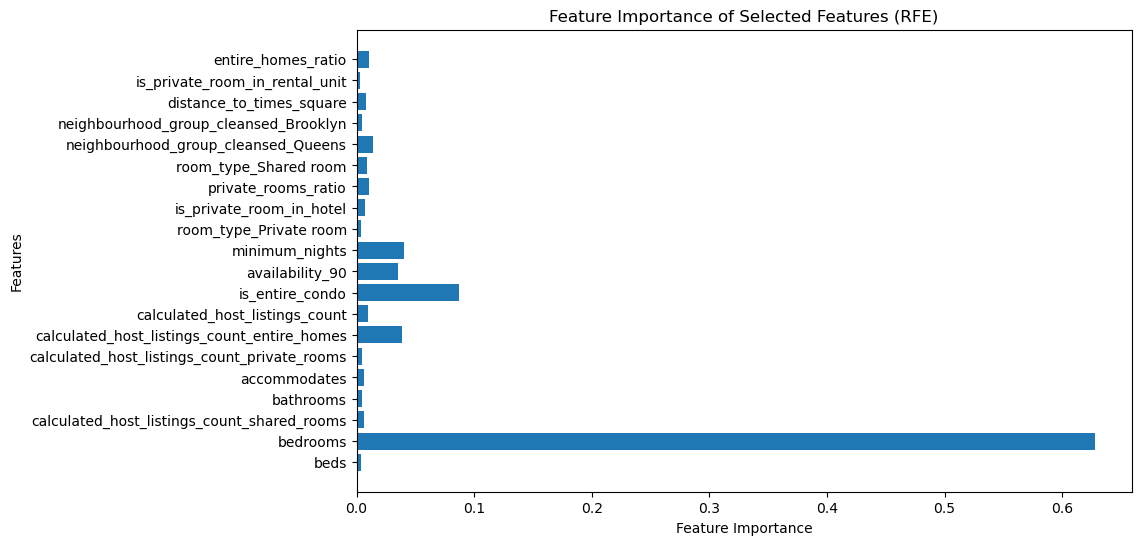

In [155]:
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe.ranking_,
    'Selected': rfe.support_
}).sort_values(by='Rank')

# Filter only the selected features
selected_features = feature_ranking[feature_ranking['Selected']]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Feature'], best_xgb_regressor.feature_importances_[rfe.support_])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of Selected Features (RFE)')
plt.gca().invert_yaxis()  # Reverse the order for better readability
plt.show()

In [41]:
# refit xgboost on selected features
xgb_model_best = xgb.XGBClassifier(objective='multi:softmax', 
                              learning_rate=0.05,
                              max_depth=8,
                              max_leaves=56,
                              n_estimators=534,
                              random_state=42)

selected_features = X_train.columns[rfe.support_]

xgb_model_best.fit(X_train[selected_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=56,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=534, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [157]:
# refit regressor
selected_features = X_train.columns[rfe.support_]
best_xgb_regressor.fit(X_train[selected_features], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=56,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=535, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [160]:
y_pred = best_xgb_regressor.predict(X_test[selected_features])
y_pred_clipped = np.clip(np.round(y_pred).astype(int), 0, 5)

print(f"accuracy: ", accuracy_score(y_test, y_pred_clipped))
print(f"rmse: ", np.sqrt(mean_squared_error(y_test, y_pred_clipped)))

accuracy:  0.5656050955414013
rmse:  0.818185035057692


**On full augmented data with distance to time square and property types:**
Best parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 54, 'n_estimators': 530}

accuracy:  0.6280254777070063
rmse:  0.8442386235556774

**submission rmse: 0.86103**

On full augmented data with one-hot encoded features, without feature selection:

Best parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 56, 'n_estimators': 500}
test accuracy:  0.6012738853503184
test rmse:  0.9138007699349777

submission rmse: 0.91297

manual adjustments:
Best parameters:  {'learning_rate': 0.06, 'max_depth': 6, 'max_leaves': 56, 'n_estimators': 520}
test accuracy:  0.6070063694267516
test rmse:  0.8997522659751341

submission rmse: 0.91004

On full data:

Best parameters:  {'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 400}
Test set accuracy:  0.564968152866242

test rmse: 0.9610

submission rmse: 1.002

manual adjustments:

Best parameters: {learning_rate=0.051,
                              max_depth=9,
                              n_estimators=400}
accuracy: 0.5738853503184713
test rmse: 0.9476756681

submission rmse: 0.93342

When setting eval_metric to 'rmse':

Best parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'max_leaves': 50, 'n_estimators': 400}
Test set accuracy:  0.5535031847133758

submission rmse: 1.016

When setting eval_metric to 'rmse' and including neighbourhood_group_cleansed:

Best parameters:  {'learning_rate': 0.009000000000000001, 'max_depth': 8, 'max_leaves': 55, 'n_estimators': 450}
Test set accuracy:  0.5452229299363057

On top 40 features:
test accuracy:  0.6140127388535032
test rmse:  0.8778955729143844


#### AdaBoost

In [52]:
from sklearn.ensemble import AdaBoostClassifier

best_tree = DecisionTreeClassifier(max_depth=8,
                                   max_leaf_nodes=45,
                                   min_samples_split=5,
                                   min_samples_leaf=19,
                                   random_state=42)

adb_model = AdaBoostClassifier(estimator=best_tree, random_state=42)

X = train_aug_full_selected.drop('price', axis=1)
y = train_aug_full_selected['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

param_grid = {
    'n_estimators': np.arange(50, 61),
    'learning_rate': [0.05],
}

cv = GridSearchCV(estimator=adb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
cv.fit(X_train, y_train)

print("Best parameters: ", cv.best_params_)

best_model_adb = cv.best_estimator_
y_pred = best_model_adb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", accuracy)



Best parameters:  {'learning_rate': 0.05, 'n_estimators': 58}
Test set accuracy:  0.5050955414012739


In [81]:
# try regressor
from sklearn.ensemble import AdaBoostRegressor

adb_model_regressor = AdaBoostRegressor(estimator=best_tree_regressor, random_state=42)

param_grid = {
    'n_estimators': np.arange(50, 61),
    'learning_rate': [0.05],
}

cv = GridSearchCV(estimator=adb_model_regressor, param_grid=param_grid, cv=5, scoring=rmse_scorer, n_jobs=-1)
cv.fit(X_train, y_train)

print("Best parameters: ", cv.best_params_)

best_model_adb = cv.best_estimator_
y_pred = best_model_adb.predict(X_test)
y_pred_clipped = np.clip(np.round(y_pred).astype(int), 0, 5)

accuracy = accuracy_score(y_test, y_pred_clipped)
print("Test set accuracy: ", accuracy)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_clipped))
print("Test set RMSE: ", rmse)

Best parameters:  {'learning_rate': 0.05, 'n_estimators': 57}
Test set accuracy:  0.4751592356687898
Test set RMSE:  0.9210904642390464


In [58]:
from sklearn.ensemble import AdaBoostClassifier

# best_tree = DecisionTreeClassifier(max_depth=10,
#                             max_leaf_nodes=45,
#                             min_samples_split=5,
#                             min_samples_leaf=4, random_state=42)

adb_model = AdaBoostClassifier(estimator=best_tree, learning_rate=0.05, n_estimators=50, random_state=42)
adb_model.fit(X_train, y_train)
y_pred = adb_model.predict(X_test)

print("test rmse:", np.sqrt(mean_squared_error(y_test, y_pred)))

test rmse: 0.962017519074559


In [82]:
best_adb_regressor = AdaBoostRegressor(estimator=best_tree_regressor, n_estimators=57, learning_rate=0.05)
best_adb_regressor.fit(X_train, y_train)
y_pred = best_adb_regressor.predict(X_test)
y_pred_clipped = np.clip(np.round(y_pred).astype(int), 0, 5)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_clipped)
print(f"Accuracy: {accuracy:.2f}")
# Calculate rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred_clipped))

Accuracy: 0.47


AdaBoost using the best decision tree:

Best parameters:  {'learning_rate': 0.01, 'n_estimators': 100}
Test set accuracy:  0.5044585987261146
Test set rmse: 1.01

AdaBoostRegressor using the best decision tree regressor:

Best parameters:  {'learning_rate': 0.05, 'n_estimators': 57}
Test set accuracy:  0.4751592356687898
Test set RMSE:  0.9210904642390464

### Stacking ensemble methods and applying ridge regression

Treat the optimized decision tree, XGBoost, and Adaboost models as base models, and use meta-features from them to train a new model. Applying ridge regression to the stacked ensemble models can regularize the coefficients, prevent overfitting, and improve generalization performance.

In [20]:
# stacked ensemble using classifiers
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso

X, y = train_aug_full_selected.drop('price', axis=1), train_aug_full_selected['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

best_tree = DecisionTreeClassifier(max_depth=8,
                                   max_leaf_nodes=45,
                                   min_samples_split=5,
                                   min_samples_leaf=19,
                                   random_state=42)

best_rf = RandomForestClassifier(n_estimators=450, 
                                 max_depth=8,
                                   max_leaf_nodes=45,
                                   min_samples_split=5,
                                   min_samples_leaf=19,
                                   random_state=42)

best_xgb = xgb.XGBClassifier(objective='multi:softmax', 
                              learning_rate=0.05,
                              max_depth=8,
                              max_leaves=56,
                              n_estimators=534,
                              random_state=42)

best_adb = AdaBoostClassifier(estimator=best_tree, learning_rate=0.05, n_estimators=50, random_state=42)


base_models = [
    best_tree,
    best_rf,
    best_xgb,
    best_adb,
    Ridge(alpha=26.0, random_state=42)
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train, y_fold_train)
        meta_features_train[val_idx, i] = model.predict(X_fold_val)
    model.fit(X_train, y_train)
    meta_features_test[:, i] = model.predict(X_test)



In [83]:
# try regressors
base_models = [
    best_tree_regressor,
    best_rf_regressor,
    best_xgb_regressor,
    best_adb_regressor,
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_fold_train, y_fold_train)
        meta_features_train[val_idx, i] = model.predict(X_fold_val)
    model.fit(X_train, y_train)
    meta_features_test[:, i] = model.predict(X_test)

In [16]:
#ridge as the meta-model
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(meta_features_train, y_train)

final_predictions = ridge_model.predict(meta_features_test)

r2 = ridge_model.score(meta_features_test, y_test)
print("R-squared:", r2)

R-squared: 0.7890533369817668


In [21]:
# try lasso as the meta-model
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01, random_state=42)
lasso_model.fit(meta_features_train, y_train)

final_predictions = lasso_model.predict(meta_features_test)
# Calculate the R-squared score
r2 = lasso_model.score(meta_features_test, y_test)
print(f"R-squared score: {r2}")

R-squared score: 0.7892010779818852


In [17]:
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print("Stacked Model RMSE:", rmse)

Stacked Model RMSE: 0.7960351212663144


In [85]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define the alpha values to search
alpha_values = {'alpha': np.arange(1, 50.0)}

# Define custom scoring for RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search
ridge_model = Ridge()
grid_search = GridSearchCV(estimator=ridge_model, param_grid=alpha_values, scoring=scorer, cv=5)
grid_search.fit(meta_features_train, y_train)

# Best alpha and corresponding score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best Alpha: {best_alpha}, Best Cross-Validated RMSE: {np.sqrt(-best_score):.4f}")

# Use the best alpha to predict on test set
final_model = Ridge(alpha=best_alpha)
final_model.fit(meta_features_train, y_train)
final_predictions = final_model.predict(meta_features_test)

r2 = final_model.score(meta_features_test, y_test)
final_predictions_rounded = np.round(final_predictions).astype(int)
accuracy = accuracy_score(y_test, final_predictions_rounded)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"Test Set Performance -> R-squared: {r2:.4f}, Accuracy: {accuracy:.4f}, RMSE: {rmse}")


Best Alpha: 14.0, Best Cross-Validated RMSE: 0.7636
Test Set Performance -> R-squared: 0.8207, Accuracy: 0.5930, RMSE: 0.7338742905816397


In [84]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score

# Define the alpha values to search
alpha_values = {'alpha': np.arange(0.00001, 0.011, 0.00001)}

# Define custom scoring for RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform grid search
lasso_model = Lasso()
grid_search = GridSearchCV(estimator=lasso_model, param_grid=alpha_values, scoring=scorer, cv=5)
grid_search.fit(meta_features_train, y_train)

# Best alpha and corresponding score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best Alpha: {best_alpha}, Best Cross-Validated RMSE: {np.sqrt(-best_score):.4f}")

# Use the best alpha to predict on test set
final_model = Lasso(alpha=best_alpha)
final_model.fit(meta_features_train, y_train)
final_predictions = final_model.predict(meta_features_test)

r2 = final_model.score(meta_features_test, y_test)
final_predictions_rounded = np.round(final_predictions).astype(int)
accuracy = accuracy_score(y_test, final_predictions_rounded)
rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

print(f"Test Set Performance -> R-squared: {r2:.4f}, Accuracy: {accuracy:.4f}, RMSE: {rmse}")


/Users/islinashan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.863e+01, tolerance: 3.294e+00
  model = cd_fast.enet_coordinate_descent(
/Users/islinashan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+01, tolerance: 3.273e+00
  model = cd_fast.enet_coordinate_descent(
/Users/islinashan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Best Alpha: 1e-05, Best Cross-Validated RMSE: 0.7636
Test Set Performance -> R-squared: 0.8208, Accuracy: 0.5924, RMSE: 0.7337685102092066


/Users/islinashan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+01, tolerance: 4.116e+00
  model = cd_fast.enet_coordinate_descent(
/Users/islinashan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e+01, tolerance: 4.116e+00
  model = cd_fast.enet_coordinate_descent(


When stacking decision tree fitted on train_full, best xgboost on train_aug_full_selected, and adaboost based on the best decision tree on train_full:

Best Alpha: 4.0, Best Cross-Validated RMSE: 0.8718
Test Set Performance -> R-squared: 0.7588, Accuracy: 0.5713, RMSE: 0.8513

When [best_tree, best_xgb, best_adb] on train_aug_full_selected:

Best Alpha: 20.0, Best Cross-Validated RMSE: 0.8704
Test Set Performance -> R-squared: 0.7605, Accuracy: 0.5624, RMSE: 0.8483

When [best_tree, best_rf, best_xgb, best_adb] on train_aug_full_selected with ridge:

Best Alpha: 19.0, Best Cross-Validated RMSE: 0.8701
Test Set Performance -> R-squared: 0.7605, Accuracy: 0.5707, RMSE: 0.8483

When [best_tree, best_rf, best_xgb, best_adb] on train_aug_full_selected with lasso:

Best Alpha: 0.0001, Best Cross-Validated RMSE: 0.8701
Test Set Performance -> R-squared: 0.7605, Accuracy: 0.5707, RMSE: 0.8482348473425885

When [best_tree, best_rf, best_xgb, best_adb] on train_aug_full_selected (with distance and property types) with lasso:
Best Alpha: 0.0006, Best Cross-Validated RMSE: 0.8228
Test Set Performance -> R-squared: 0.7880, Accuracy: 0.5930, RMSE: 0.7980824565827066

**submission rmse: 0.80979**

When [best_rf, best_xgb, best_adb] on train_aug_full_selected (with distance and property types) with lasso:
Best Alpha: 0.0001, Best Cross-Validated RMSE: 0.8238
Test Set Performance -> R-squared: 0.7881, Accuracy: 0.5943, RMSE: 0.7978192965726395

**submission rmse: 0.80832**

When [best_tree, best_rf, best_xgb, best_adb] on train_aug_full_selected (with distance and property types) with ridge:

Best Alpha: 13.0, Best Cross-Validated RMSE: 0.8228
Test Set Performance -> R-squared: 0.7880, Accuracy: 0.5930, RMSE: 0.7981108584088519

**submission rmse: 0.80997**

Lasso and ridge have comparable performance on the test sets. Both achieved an rmse of 0.86859 on the unseen test set.

**with regressors**

Best Alpha: 1e-05, Best Cross-Validated RMSE: 0.7636
Test Set Performance -> R-squared: 0.8208, Accuracy: 0.5924, RMSE: 0.7337685102092066

**submission rmse: 0.76699**

### Apply best model(s) to test data

In [26]:
test_augmented_full = pd.read_csv('test_augmented_full.csv')
test_augmented_full.columns

Index(['id', 'name', 'description', 'property_type', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'room_type',
       'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'instant_bookable',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores

In [86]:
test_aug_full_selected = test_augmented_full.copy()[[
       'neighbourhood_group_cleansed', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 
       'host_has_profile_pic', 'host_identity_verified',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'instant_bookable',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month', 'has_reviews',
       'amenities_count', 'host_time', 'first_review_time',
       'last_review_time', 'review_time_difference', 'entire_homes_ratio',
       'private_rooms_ratio', 'review_scores_rating_scaled',
       'review_scores_accuracy_scaled', 'review_scores_cleanliness_scaled',
       'review_scores_checkin_scaled', 'review_scores_communication_scaled',
       'review_scores_location_scaled', 'review_scores_value_scaled','reviews_safe',
       'reviews_convenient', 'reviews_clean', 'reviews_quiet',
       'reviews_luxury', 'name_new', 'name_luxury', 'name_big', 'reviews_big',
       'description_luxury', 'description_big', 'description_convenient',
       'is_entire_rental_unit', 'is_private_room_in_rental_unit',
       'is_private_room_in_home', 'is_entire_home',
       'is_private_room_in_townhouse', 'is_private_room_in_hotel',
       'is_entire_condo', 'distance_to_times_square']]

In [87]:
# one-hot encode the categorical features
categorical_vars = test_aug_full_selected.select_dtypes(include=['object','bool']).columns
exclude_vars = ['host_response_time']
categorical_vars = [var for var in categorical_vars if var not in exclude_vars]
# one-hot encode the categorical features
if 'host_response_time' in test_aug_full_selected.columns:
    mapping = {'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more': 3}
    test_aug_full_selected['host_response_time'] = test_aug_full_selected['host_response_time'].map(mapping)
test_aug_full_selected = pd.get_dummies(test_aug_full_selected, columns=categorical_vars, drop_first=True)
print(test_aug_full_selected.head())

   host_response_time  host_response_rate  host_acceptance_rate  \
0                   1           91.318456             77.433283   
1                   0           99.000000             23.000000   
2                   1           91.318456             77.433283   
3                   2           70.000000             37.000000   
4                   1          100.000000             75.000000   

   calculated_host_listings_count  \
0                               1   
1                             719   
2                               1   
3                              36   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            0   
2                                            1   
3                                           18   
4                                            1   

   calculated_host_listings_count_private_rooms  \
0                     

In [30]:
# check no nans

print(test_aug_full_selected.isna().any().any())

False


In [94]:
# apply stacked ensemble model

import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import xgboost as xgb

# Prepare data
X, y = train_aug_full_selected.drop('price', axis=1), train_aug_full_selected['price']
X_test = test_aug_full_selected

# Define base models

base_models = [
    best_rf_regressor,
    best_xgb_regressor,
    best_adb_regressor,
]

# Generate meta-features using k-fold for out-of-fold predictions
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features_train = np.zeros((X.shape[0], len(base_models)))
meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

for i, model in enumerate(base_models):
    test_predictions = np.zeros((X_test.shape[0], kf.get_n_splits()))
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        meta_features_train[val_idx, i] = model.predict(X_val_fold)
        test_predictions[:, fold] = model.predict(X_test)

    meta_features_test[:, i] = test_predictions.mean(axis=1)

# Train the final Ridge/Lasso model
final_model = Ridge(alpha=14.0)
final_model.fit(meta_features_train, y)

# Make predictions on the test set
final_predictions = final_model.predict(meta_features_test)

# Check predictions
print("Final Predictions:", final_predictions)




Final Predictions: [4.79021744 0.16884778 3.21149181 ... 0.165959   3.42742612 0.97925377]


In [95]:
y_pred = np.round(final_predictions).astype(int)
y_pred = np.clip(y_pred, 0, 5)
print(y_pred)

[5 0 3 ... 0 3 1]


In [42]:
# xgb model best classifier
# xgb_model_best = xgb.XGBClassifier(objective='multi:softmax', 
#                               learning_rate=0.05,
#                               max_depth=7,
#                               max_leaves=54,
#                               n_estimators=530,
#                               random_state=42)

# X_train, y_train = train_aug_full_selected.drop('price', axis=1), train_aug_full_selected['price']

# xgb_model_best.fit(X_train, y_train)
# y_pred = xgb_model_best.predict(test_aug_full_selected)

In [96]:
# formulate result into submission format
submission = pd.DataFrame({'id': test_augmented_full['id'], 'price': y_pred})
print(submission.head())
print(y_pred)

# export to csv
submission.to_csv('submission2.csv', index=False)

      id  price
0   3917      5
1   1885      0
2   1305      3
3  19328      1
4  16511      3
[5 0 3 ... 0 3 1]


best_rf + best_xgb + best_adb -> best_lasso -> submission rmse: 0.80777 (data with distance and property type)

best_tree + best_xgb + best_adb -> best_lasso -> submission rmse: 0.86859

**With regressors**:

best_rf_regressor + best_xgb_regressor + best_adb_regressor -> best_lasso -> submission rmse: 0.76602

best_rf_regressor + best_xgb_regressor + best_adb_regressor -> best_ridge -> submission rmse: 0.76583 **BEST**

best_tree_regressor + best_rf_regressor + best_xgb_regressor + best_adb_regressor -> best_lasso -> submission rmse: 0.76699

Note:

In general, regressors have lower accuracy than classifiers, but they are more robust to outliers and noise, and considers the ordinal relationship of the target variable (0 misclassified as 5 is penalized more than 0 misclassified as 1). As a result, regressors produced lower rmse.